# Multilayer Perceptron

## Import Pacakges

In [34]:
import tensorflow as tf
import torch
import torch.nn.functional as F
from torch.utils import data
from torch.autograd import Variable
from torch import nn

import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions

from d2l import tensorflow as d2l_tf
from d2l import torch as d2l_torch

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print(torch.__version__)

1.8.0


In [4]:
plt.rcParams["figure.figsize"] = (8, 8)

* https://www.tensorflow.org/tutorials/keras/classification
* https://www.tensorflow.org/tutorials/keras/text_classification
* https://towardsdatascience.com/how-to-train-a-classification-model-with-tensorflow-in-10-minutes-fd2b7cfba86
* https://www.kaggle.com/code/salehahmedrony/deep-learning-decision-boundary/notebook

## Problem - Classfication

### Global Variables

In [81]:
LEARNING_RATE = 0.03
NUM_EPOCHS = 20
BATCH_SIZE = 64
INIT_STDDEV = 0.01 # random initialisation from normal distribution

### Data Preparation

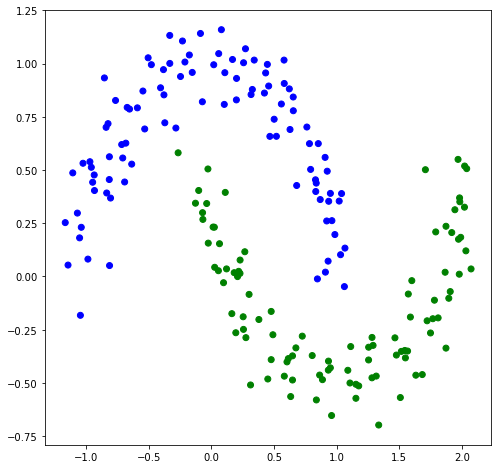

In [6]:
base_colors = list(plt.cm.colors.BASE_COLORS.keys())
X, y = datasets.make_moons(n_samples=200, noise=.1, random_state=0)
plt.scatter(X[:,0], X[:, 1], color=[base_colors[int(i)] for i in y])

#### Tensorflow Data Prep

In [100]:
features, labels = tf.constant(X), tf.constant(y.astype(np.float))

/var/folders/sd/mz_l847n579df0n5l438fcl00000gr/T/ipykernel_66421/652541238.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features, labels = tf.constant(X), tf.constant(y.astype(np.float))


In [101]:
features[:10], labels[:10]

(<tf.Tensor: shape=(10, 2), dtype=float64, numpy=
 array([[ 0.79235735,  0.50264857],
        [ 1.63158315, -0.4638967 ],
        [-0.06710927,  0.26776706],
        [-1.04412427, -0.18260761],
        [ 1.76704822, -0.19860987],
        [ 1.90607398, -0.07109159],
        [ 0.96219213,  0.26198607],
        [ 0.88681385, -0.48489624],
        [ 0.8689352 ,  0.36109278],
        [ 1.15352953, -0.57235293]])>,
 <tf.Tensor: shape=(10,), dtype=float64, numpy=array([0., 1., 1., 0., 1., 1., 0., 1., 0., 1.])>)

In [111]:
def load_array_tf(data_arrays, batch_size, is_train=True):  #@save
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

In [113]:
data_iter = load_array_tf((features, labels), BATCH_SIZE)

Metal device set to: Apple M1 Pro


2022-04-19 08:48:14.867676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-19 08:48:14.868420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Pytorch Data Prep

In [127]:
features = torch.tensor(X)
labels = torch.tensor(y)

In [128]:
features[:10], labels[:10]

(tensor([[ 0.7924,  0.5026],
         [ 1.6316, -0.4639],
         [-0.0671,  0.2678],
         [-1.0441, -0.1826],
         [ 1.7670, -0.1986],
         [ 1.9061, -0.0711],
         [ 0.9622,  0.2620],
         [ 0.8868, -0.4849],
         [ 0.8689,  0.3611],
         [ 1.1535, -0.5724]], dtype=torch.float64),
 tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 1]))

In [129]:
def load_array_pt(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [130]:
data_iter = load_array_pt((features, labels), BATCH_SIZE)

### Model Training

#### TF Keras Sequential API 

Need to rerun tensorflow data prep part!

In [119]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [120]:
initializer = tf.initializers.RandomNormal(stddev=INIT_STDDEV)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for multiclass
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
metrics=[tf.metrics.BinaryAccuracy(threshold=0.0), 'accuracy']

**Logistic Regression**

In [121]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_dim=2,
                          kernel_initializer=initializer)
])

# # Alternatively
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.InputLayer(input_shape=(2, ))
# model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

In [122]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.fit(data_iter,
          epochs=NUM_EPOCHS)

Epoch 1/10
 1/25 [>.............................] - ETA: 8s - loss: 0.6949 - binary_accuracy: 0.2500 - accuracy: 0.1250

2022-04-15 22:55:35.059604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 7ms/step - loss: 0.6621 - binary_accuracy: 0.5000 - accuracy: 0.7600
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6057 - binary_accuracy: 0.5000 - accuracy: 0.8150
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5625 - binary_accuracy: 0.5000 - accuracy: 0.8050
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5289 - binary_accuracy: 0.5000 - accuracy: 0.8100
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5022 - binary_accuracy: 0.5000 - accuracy: 0.8100
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.4806 - binary_accuracy: 0.5000 - accuracy: 0.8100
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.4623 - binary_accuracy: 0.5000 - accuracy: 0.8100
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.4474 - binary_accuracy: 0.5000 - accuracy: 0.8100
Epoch 9/10
25/25 [=

2022-04-15 22:55:36.864538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

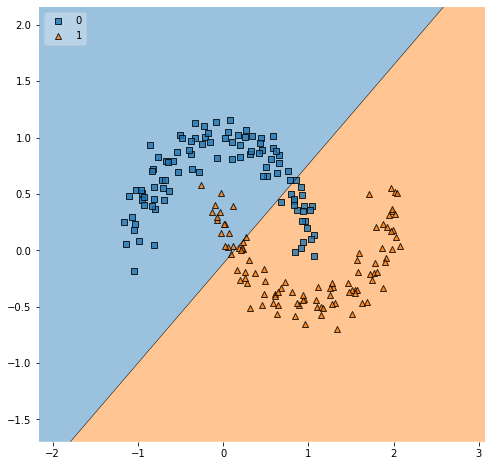

In [124]:
plot_decision_regions(X=X, y=y, clf=model, legend=2)

* The input layer can be ommited here and model can be fitted on input data at a later stage. This way however, `model.summary()` can only be called later when the input data shape is known to the object.
* Any types of feature preprocessing e.g. normalisation (`tf.keras.layers.Normalization`) can also be included in the sequential steps as the initial layer.

**MLP: Model Architecture** 

In [127]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_dim=2), # input shape is defined here
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [128]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 8)                 24        
                                                                 
 dense_41 (Dense)            (None, 8)                 72        
                                                                 
 dense_42 (Dense)            (None, 1)                 9         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


* Here we can only call `model.summary()` if the object knows about the input shape

**MLP: Compile model then train**

In [129]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05),
              loss=loss,
              metrics=metrics)
model.fit(data_iter,
          epochs=NUM_EPOCHS)

Epoch 1/10


/Users/work/miniforge3/envs/py38/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/work/miniforge3/envs/py38/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-04-15 22:58:01.799069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 7ms/step - loss: 0.4829 - binary_accuracy: 0.5000 - accuracy: 0.7500
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.2938 - binary_accuracy: 0.5000 - accuracy: 0.8700
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3171 - binary_accuracy: 0.5000 - accuracy: 0.8500
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2454 - binary_accuracy: 0.5000 - accuracy: 0.8700
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2466 - binary_accuracy: 0.5000 - accuracy: 0.8950
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2128 - binary_accuracy: 0.5000 - accuracy: 0.9000
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2065 - binary_accuracy: 0.5000 - accuracy: 0.9050
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.1823 - binary_accuracy: 0.5000 - accuracy: 0.9300
Epoch 9/10
25/25 [=

**MLP: Decision Boundary**

2022-04-15 22:58:06.103088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

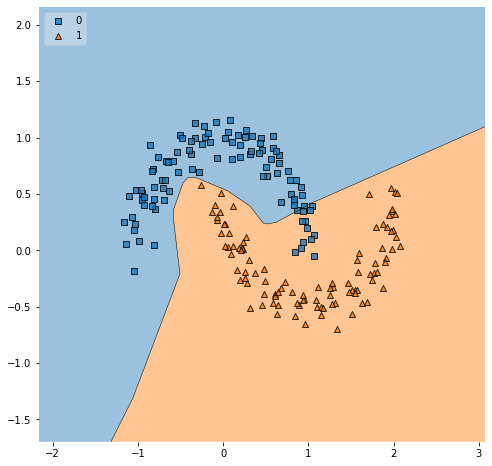

In [130]:
plot_decision_regions(X=X, y=y, clf=model, legend=2)

#### TF Keras Functional API

In [137]:
inputs = tf.keras.Input(shape=(2,))
h1 = tf.keras.layers.Dense(8, activation="relu")(inputs)
h2 = tf.keras.layers.Dense(8, activation="relu")(h1)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h2)

In [138]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mlp_model")
model.summary()

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_46 (Dense)            (None, 8)                 24        
                                                                 
 dense_47 (Dense)            (None, 8)                 72        
                                                                 
 dense_48 (Dense)            (None, 1)                 9         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [139]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05),
              loss=loss,
              metrics=metrics)
model.fit(data_iter,
          epochs=NUM_EPOCHS)

Epoch 1/10


2022-04-15 23:01:30.809233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 8ms/step - loss: 0.5185 - binary_accuracy: 0.7400 - accuracy: 0.7600
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3922 - binary_accuracy: 0.5000 - accuracy: 0.8450
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3095 - binary_accuracy: 0.5000 - accuracy: 0.9000
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2372 - binary_accuracy: 0.5000 - accuracy: 0.9350
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.1648 - binary_accuracy: 0.5000 - accuracy: 0.9500
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.1282 - binary_accuracy: 0.5000 - accuracy: 0.9600
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.1010 - binary_accuracy: 0.5000 - accuracy: 0.9800
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.0863 - binary_accuracy: 0.5000 - accuracy: 0.9700
Epoch 9/10
25/25 [=

**MLP: Decision Boundary**

2022-04-15 23:01:33.161472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

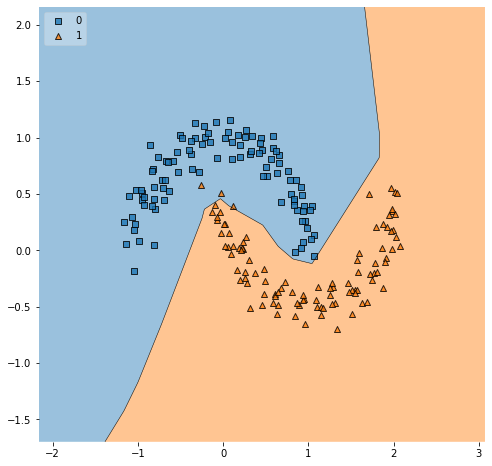

In [140]:
plot_decision_regions(X=X, y=y, clf=model, legend=2)

#### Pytorch 

References
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html
* https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
* https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb
* https://towardsdatascience.com/building-neural-network-using-pytorch-84f6e75f9a

Need to rerun Pytorch data prep part first!

**Define Training Procedure**

In [110]:
def train_batch(model, train_iter, features, labels, loss, num_epochs, optimizer):
    for epoch in range(num_epochs):
        for X, y in train_iter:
            pred_y = model(X.float())
            l = loss(pred_y.squeeze(), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        l = loss(model(features.float()).squeeze(), labels.float())
        print(f'epoch {epoch + 1}, loss {l:f}')

In [103]:
def train_epoch(model, X, y, loss, num_epochs, optimizer):
    for epoch in range(num_epochs):
        pred_y = model(X.float())
        l = loss(pred_y.squeeze(), y.float())
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        print(f'epoch {epoch + 1}, loss {l:f}')

**Define Architecture**

In [74]:
class Feedforward(torch.nn.Module):
    
    def __init__(self, input_size, h1_size, h2_size):

        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.h1_size  = h1_size
        self.h2_size = h2_size

        self.fc1 = torch.nn.Linear(self.input_size, self.h1_size)
        # self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.h1_size, self.h2_size)
        self.fc3 = torch.nn.Linear(self.h2_size, 1)
        # self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x

In [131]:
# class Feedforward(torch.nn.Module):
    
#         def __init__(self, input_size, hidden_sizes, output_size):
            
#             super(Feedforward, self).__init__()
#             self.input_size = input_size
#             self.output_size = output_size
#             self.hidden_sizes  = hidden_sizes
            
#             # self.fc1 = torch.nn.Linear(self.input_size, self.hidden_sizes[0])
#             self.hidden = nn.ModuleList()
#             self.hidden.append(torch.nn.Linear(self.input_size, self.hidden_sizes[0]))
#             for k in range(len(self.hidden_sizes)-1):
#                 self.hidden.append(torch.nn.Linear(self.hidden_sizes[k], self.hidden_sizes[k+1]))
#             self.hidden.append(torch.nn.Linear(self.hidden_sizes[-1], self.output_size))
            
#         def forward(self, x):

#             self.last_fc = self.hidden.pop()
#             for fc in self.hidden:
#                 x = F.relu(fc(x))
#             # last layer is sigmoid for binary classification
#             x = torch.sigmoid(self.last_fc(x))
            
#             return x

In [56]:
# def init_weights(m):
#     if type(m) == nn.Linear:
#         nn.init.normal_(m.weight, std=INIT_STDDEV)

# model.apply(init_weights)

**Instantiate Model**

In [82]:
model = Feedforward(2, 32, 32)
model

Feedforward(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

**Define Loss and Optimiser**

In [133]:
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

**Define Architecture 2**

In [104]:
input_size = 2
hidden_sizes = (32, 32)
output_size = 1

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Sigmoid()
                      )

# from collections import OrderedDict
# model = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, hidden_sizes[0])),
#                                    ('act1', nn.Tanh()),
#                                    ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
#                                    ('act2', nn.Tanh()),
#                                    ('fc3', nn.Linear(hidden_sizes[1], output_size)),
#                                    ('out', nn.Sigmoid())
#                                    ]))

model

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

In [105]:
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [134]:
train_batch(model, data_iter, features, labels, loss, NUM_EPOCHS, optimizer)

epoch 1, loss 0.551519
epoch 2, loss 0.552853
epoch 3, loss 0.549842
epoch 4, loss 0.547319
epoch 5, loss 0.562359
epoch 6, loss 0.556174
epoch 7, loss 0.542052
epoch 8, loss 0.534994
epoch 9, loss 0.539248
epoch 10, loss 0.539498
epoch 11, loss 0.536870
epoch 12, loss 0.530401
epoch 13, loss 0.528129
epoch 14, loss 0.511529
epoch 15, loss 0.508736
epoch 16, loss 0.513093
epoch 17, loss 0.511382
epoch 18, loss 0.508005
epoch 19, loss 0.506070
epoch 20, loss 0.505363


In [109]:
# train_epoch(model, features, labels, loss, NUM_EPOCHS, optimizer)

In [135]:
def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels_predicted = model(dataset)
    ax.scatter(dataset[:, 0], dataset[:, 1], c=labels.reshape(labels.size()[0]), cmap=color_map, lw=0)
    plt.show()
    return fig, ax

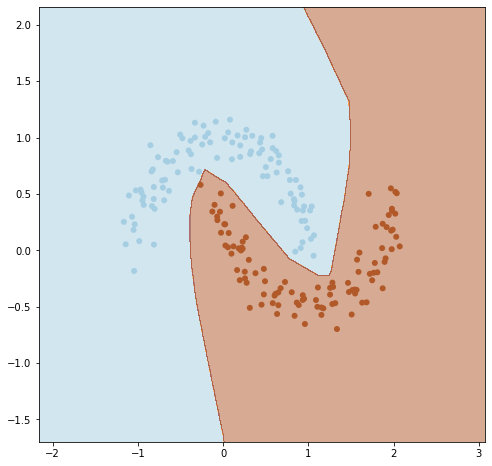

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [136]:
plot_decision_boundary(features.float(), labels.float(), model)